In [358]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append(r'C:\Users\benny\Documents\Brus\CiDAN\gae\gae')

from CiDAN.model import VAE, CiDAN

import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sparse
from sklearn.metrics import precision_recall_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
SEED = 1
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [197]:
node_num = 10
batch_size = 20

adj = torch.from_numpy(np.random.randint(2,size=(batch_size,nodes_num,nodes_num))).double()

vae = VAE(node_num, hidden_size = 256, ZDIMS = 128, batch_size = batch_size-1)
vae = vae.double()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

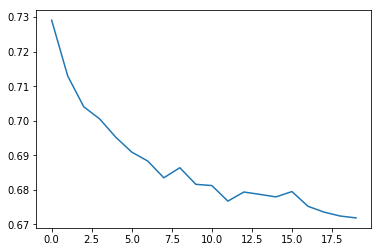

In [198]:
vae.train()
epochs = 20
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()

    recon_batch, mu, logvar = vae(adj[1:])
    loss = vae.loss_function(recon_batch, adj[:-1], mu, logvar)
    loss.backward()
    optimizer.step()
    
    losses.append(loss)

plt.plot(losses)
plt.show()

In [203]:
torch.cat((adj,adj),1).shape

torch.Size([20, 20, 10])

<h3> CiDAN

In [208]:
node_numA = 10
node_numB = 7
batch_size = 20

adjA = torch.from_numpy(np.random.randint(2,size=(batch_size,node_numA,node_numA))).double()
adjB = torch.from_numpy(np.random.randint(2,size=(batch_size,node_numB,node_numB))).double()


cidan = CiDAN(node_numA,node_numB, hidden_size = 256, ZDIMS = 128, batch_size = batch_size-1)
cidan = cidan.double()

optimizer = optim.Adam(cidan.parameters(), lr=1e-3)

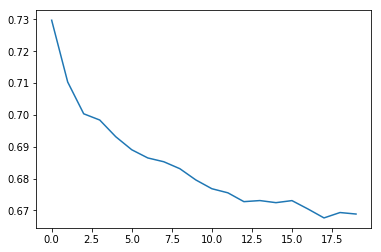

In [218]:
cidan.train()
epochs = 20
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()

    recon_batchA, recon_batchB , muA, muB, logvarA, logvarB = cidan(adjA[1:], adjB[1:])
    loss = vae.loss_function(recon_batchA, adjA[:-1], muA, logvarA)
    loss.backward()
    optimizer.step()
    
    losses.append(loss)

plt.plot(losses)
plt.show()

<h3> VAE real Data

In [412]:
with open (r'C:\Users\benny\Documents\Brus\CiDAN\gae\gae\CiDAN/Reality_Mining_MIT.adjs', 'rb') as f:
    data = pickle.load(f)[20:]
data = list(map(sparse.csr_matrix.todense, data))
data_torch = torch.from_numpy(np.array(data))

In [413]:
node_num = data_torch.shape[1]
batch_size = data_torch.shape[0]
CUDA = True


X = data_torch[:batch_size]

vae = VAE(node_num, hidden_size = 256, ZDIMS = 128, batch_size = batch_size-1)
vae = vae.double()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [428]:
vae.train()
epochs = 20
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()

    recon_batch, mu, logvar = vae(X[1:])
    loss = vae.loss_function(recon_batch, X[1:], mu, logvar)
    loss.backward()
    optimizer.step()
    
    print(loss)
    losses.append(loss)

plt.plot(losses)
plt.show()

tensor(0.2071, dtype=torch.float64)
tensor(0.1872, dtype=torch.float64)
tensor(0.1698, dtype=torch.float64)
tensor(0.1547, dtype=torch.float64)
tensor(0.1407, dtype=torch.float64)


KeyboardInterrupt: 

In [431]:
vae.eval()
recon_batch, mu, logvar = vae(X[1:])
recon_batch = recon_batch.view((-1,node_num,node_num))

In [432]:
y_pred = recon_batch.view(-1).data.numpy()
y_true = X[1:].reshape(-1).data.numpy()

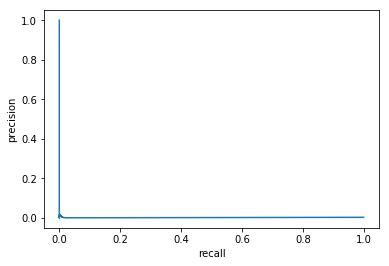

In [433]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [434]:
recon_batch

tensor([[[ 1.3241e-09,  8.7038e-09,  8.8530e-10,  ...,  5.4740e-08,
           3.8856e-10,  1.4545e-11],
         [ 2.1989e-07,  4.1559e-10,  3.1255e-10,  ...,  4.6406e-10,
           1.3859e-09,  2.7724e-08],
         [ 1.0512e-10,  1.0092e-10,  2.2706e-11,  ...,  1.8267e-09,
           5.0053e-08,  1.1675e-08],
         ...,
         [ 4.4723e-10,  1.5276e-07,  4.1635e-11,  ...,  9.9812e-10,
           2.3496e-12,  7.6469e-10],
         [ 2.9454e-11,  1.9668e-08,  5.4459e-11,  ...,  2.5258e-10,
           2.5120e-08,  1.9349e-09],
         [ 5.8021e-10,  1.9012e-10,  1.2192e-10,  ...,  3.0422e-09,
           6.3503e-10,  1.3684e-09]],

        [[ 3.5295e-02,  4.8196e-02,  3.2308e-02,  ...,  6.4322e-02,
           2.9505e-02,  1.7517e-02],
         [ 8.1918e-02,  2.8332e-02,  2.9147e-02,  ...,  3.2617e-02,
           3.8228e-02,  6.0821e-02],
         [ 2.5189e-02,  2.7029e-02,  2.0538e-02,  ...,  3.9283e-02,
           6.5101e-02,  5.3949e-02],
         ...,
         [ 3.0509e-02,  7